# Autoregressive Model (AR)

In this Notebook, we will focus on: 1) Partial autocorrection function; 2) AR completion from scratch.

Source: 1) https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/; 2) https://timeseriesreasoning.com/contents/partial-auto-correlation/

## Partial autocorrelation function

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps. We can define the PACF with lag 2 just described as

$\operatorname{PACF}\left(\boldsymbol{T}_{i}, \boldsymbol{k}=\mathbf{2}\right)=\frac{\operatorname{Cov}\left(T_{i}\left|T_{(i-1)}, T_{(i-2)}\right| T_{(i-1)}\right)}{\sigma_{T_{i} \mid T_{(i-1)}} \times \sigma_{T_{(i-2)} \mid T_{(i-1)}}}$

In [1]:
import pandas as pd
from sklearn import linear_model

#Read the data into a pandas DataFrame and convert it to stationarity
df = pd.read_csv('AAPL.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df['Open_diff'] = df['Open'].diff().diff()

In [2]:
#add two columns containing the LAG=1 and LAG=2 version of the data to the DataFrame
df['T_(i-1)'] = df['Open_diff'].shift(1)
df['T_(i-2)'] = df['Open_diff'].shift(2)

In [3]:
#drop the top four rows as they contain NaNs after shifting
df = df.drop(df.index[[0, 1, 2, 3]])

In [4]:
#fit a linear regression model on T_i and T_i-1 and add it's predictions to the DataFrame as a new column
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['Open_diff'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_i|T_(i-1)'] = lm.predict(df_X)

In [5]:
#create the time series of residuals corresponding to the predictions of this model and add it to the DataFrame.
# This gives us the first one of the two time series we need for calculating the PACF for X at LAG=2
#Observed minus predicted
df['Residual_T_i|T_(i-1)'] = df['Open_diff'] - df['Predicted_T_i|T_(i-1)']

In [6]:
# #repeat the above procedure to calculate the second time series of residuals
lm = linear_model.LinearRegression()
df_X = df[['T_(i-1)']] #Note the double brackets! [[]]
df_y = df['T_(i-2)'] #Note the single brackets! []
model = lm.fit(df_X,df_y)
df['Predicted_T_(i-2)|T_(i-1)'] = lm.predict(df_X)
#Observed minus predicted
df['Residual_T_(i-2)|T_(i-1)'] = df['T_(i-2)'] - df['Predicted_T_(i-2)|T_(i-1)']

#Finally, apply the formula for Pearson's r to the two time series of residuals to get the value of the PACF at LAG=2
print(df.corr(method='pearson')['Residual_T_i|T_(i-1)']['Residual_T_(i-2)|T_(i-1)'])

-0.36584141912137275


In [7]:
#or cheat, we can use a Python library statsmodels to calculate PACF
from statsmodels.tsa.stattools import pacf
print(pacf(df['Open_diff'], nlags=2)[2])

-0.36739845448527164


/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## AR completion from scratch.

In this part, we use AR model to predict Apple's stock price. Again, the data is from Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021). In order to help you gain the insights of AR model, instead of using exsiting Python Statsmodels library (https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), I tend to show an example to implement AR from scratch. Addtionally, you can use this Statsmodels library to test performance by yourself. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
df=pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Open']

In [10]:
df

,Open
Date,
2020-12-28,133.990005
2020-12-29,138.050003
2020-12-30,135.580002
2020-12-31,134.080002
2021-01-04,133.520004
...,...
2021-12-20,168.279999
2021-12-21,171.559998
2021-12-22,173.039993


### Equation for AR model : <br>
$Y_{t}=c+\sum_{i=1}^{p} \varphi_{i} Y_{t-i}+\varepsilon_{t}=c+\varphi_{1} Y_{t-1}+\varphi_{2} Y_{t-2}+\ldots \ldots \ldots \ldots \ldots+\varphi_{p} Y_{t-p}+\varepsilon_{t}$

In [11]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Open'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Open'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

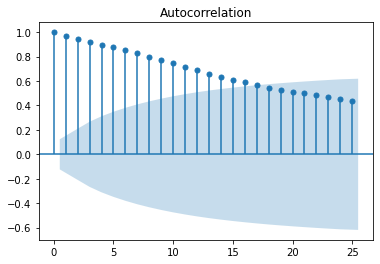

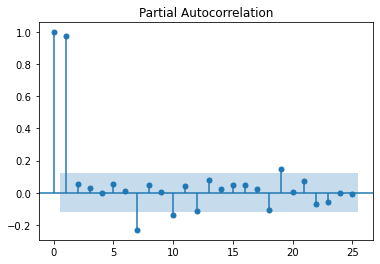

In [12]:
ACF = plot_acf(df.Open.dropna(),lags=25)
# with the PACF, we can figure out how many lags we need in the AR model.
PACF = plot_pacf(df.Open.dropna(),lags=25)

From the above figure of PACF, we can use 3 as the lag number.

In [13]:
lag_num = 2

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [14]:
[df_train,df_test,theta,intercept,RMSE] = AR(lag_num,pd.DataFrame(df.Open))

The RMSE is : 3.2268222617815465 , Value of p :  2


<AxesSubplot:xlabel='Date'>

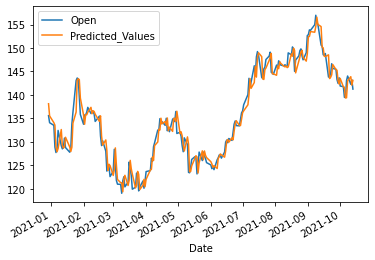

In [15]:
df_train[['Open','Predicted_Values']].plot()

<AxesSubplot:xlabel='Date'>

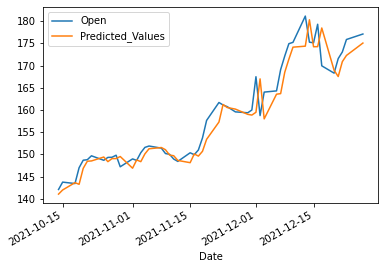

In [16]:
df_test[['Open','Predicted_Values']].plot()